In [2]:
#import libraries
import os
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from tensorflow import keras
from tensorflow.keras import layers, models

from dataclasses import dataclass
import platform

# Text formatting
bold = "\033[1m"
end = "\033[0m"

block_plot=False

%matplotlib inline

In [3]:
#Set Seeds
def set_seeds():
    # fix random seeds
    SEED_VALUE = 42

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
    
#     physical_devices = tf.config.list_physical_devices("GPU")
#     try:
#         tf.config.experimental.set_memory_growth(physical_devices[0], True)
#     except:
#         # Invalid device or cannot modify virtual devices once initialized.
#         pass

    return

set_seeds()

In [4]:
# Creating a MirroredStrategy for distributed training.
# This strategy effectively replicates the model's layers on each GPU or other available devices,
# syncing their weights after each training step.
DISTRIBUTE_STRATEGY = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [5]:
# Creating a MirroredStrategy for distributed training.
# This strategy effectively replicates the model's layers on each GPU or other available devices,
# syncing their weights after each training step.
DISTRIBUTE_STRATEGY = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [6]:
# If required, update the root_dir path according to the dataset path.

#root_dir = r"/kaggle/input/opencv-tf-project-1-image-classification-round-3/dataset"
root_dir = r"./dataset"

train_dir = os.path.join(root_dir, "Train")
valid_dir = os.path.join(root_dir, "Valid")

In [7]:
def list_folders(startpath):
    for root, _, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root):<8}')


list_folders(root_dir)

dataset 
    .ipynb_checkpoints
    Test    
        .ipynb_checkpoints
    Train   
        cow     
        elephant
        horse   
        spider  
    Valid   
        cow     
        elephant
        horse   
        spider  


In [8]:
print(f"{bold}Training Classes:{end} ")
for i in os.listdir(train_dir):
    print(i)
    
print("------------")

print(f"{bold}Validation Classes:{end} ")
for j in os.listdir(valid_dir):
    print(j)

Training Classes: 
cow
elephant
horse
spider
------------
Validation Classes: 
cow
elephant
horse
spider


In [9]:
num_train_files = 0
num_valid_files = 0

### YOUR CODE HERE
def count_files(directory):
    return sum(len(files) for _,_, files in os.walk(directory))

num_train_files = count_files(train_dir)
num_valid_files = count_files(valid_dir)
###

print(f"{bold}Number of Training samples: {end}{num_train_files}")
print(f"{bold}Number of Validation samples: {end}{num_valid_files}")

Number of Training samples: 3997
Number of Validation samples: 786


Class: cow
Image: 6973409.jpg
Size: (293, 300)


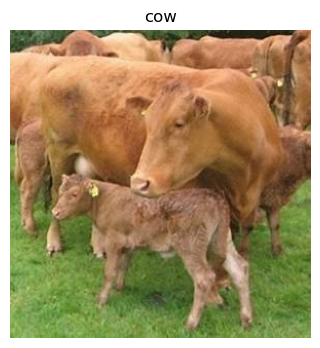

In [10]:
target = "cow"

# Load image and print its shape/size.

### YOUR CODE HERE
class_name = target

# Select one random image from each class
#for class_name in classes:
class_path = os.path.join(train_dir, class_name)
if os.path.isdir(class_path):  # Ensure it's a directory
    image_file = random.choice(os.listdir(class_path))  # Pick a random image
    image_path = os.path.join(class_path, image_file)
    
    # Load image
    img = Image.open(image_path)
    
    # Print image size
    print(f"Class: {class_name}")
    print(f"Image: {image_file}")
    print(f"Size: {img.size}")  # (width, height)
    
    # Display image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")  # Hide axis
    plt.title(class_name)
    plt.show()
###

In [36]:
#Augmentation
### YOUR CODE HERE
def data_augmentation_preprocess():
    # Combine multiple augmentations in a single processing pipeline.
    """Returns a Sequential model with data augmentation layers."""
    data_augmentation_pipeline = keras.Sequential([
    #    layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2, fill_mode='nearest'),
        layers.RandomZoom(height_factor=(-0.5, 0.5),                # Increase zoom range
                          width_factor=(-0.5, 0.5),
                          fill_mode='nearest'),
    #    layers.RandomContrast(0.1),
    ], name="data_augmentation")

    return data_augmentation_pipeline
###

In [37]:
def get_data(*, data_root, target_size=(224, 224), batch_size=32, data_augmentation=False):
    ### YOUR CODE HERE

    train_path = os.path.join(data_root, "Train")
    train_dataset = image_dataset_from_directory(
        train_path, 
        label_mode='categorical',
        color_mode='rgb', 
        batch_size=batch_size, 
        image_size=target_size, 
        shuffle=True,
    )

    valid_path = os.path.join(data_root, "Valid")    
    valid_dataset = image_dataset_from_directory(
        valid_path, 
        label_mode='categorical',
        color_mode='rgb', 
        batch_size=batch_size, 
        image_size=target_size, 
        shuffle=False, 
    )
    
    if data_augmentation: 
        data_augmentation_pipeline = data_augmentation_preprocess()
        train_dataset = train_dataset.map(lambda x, y: (data_augmentation_pipeline(x), y))

    # Resize if needed
#    def preprocess_image(image, label):
#        image = tf.image.resize(image, [224, 224])
#        return image, label

#    train_dataset = train_dataset.map(preprocess_image)
#    valid_dataset = valid_dataset.map(preprocess_image)
    
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)    
    valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)
    
  ###
    return train_dataset, valid_dataset

In [38]:
@dataclass
class TrainingConfig:
    # Defining the batch size for model training.
    # The batch size is set to be some integer times the  number of devices in synchronization as per the distributed strategy.
    # This means that the overall batch of data is divided equally across all the devices used in the distributed training.
    # By scaling the batch size with the number of replicas (devices), each device processes a batch of size, in this case, 4.
   
    # This approach helps in efficient utilization of the computational power of all the devices involved in training.
    BATCH_SIZE: int = 32 * DISTRIBUTE_STRATEGY.num_replicas_in_sync

    EPOCHS: int = 100
    LEARNING_RATE: float = 0.0002

    # For tensorboard logging and saving checkpoints
    root_log_dir = os.path.join("Logs_Checkpoints", "Model_logs")
    root_checkpoint_dir = os.path.join("Logs_Checkpoints", "Model_checkpoints")

    # Current log and checkpoint directory.
    log_dir = "version_0"
    checkpoint_initial = "version_0"

    # Use multiprocessing during training.
    use_multiprocessing: bool = True if platform.system() == "Linux" else False
        
    # Number of workers to use for training.
    num_workers: int = 4

In [19]:
@dataclass
class DatasetConfig:
#    DATA_ROOT: str = r"/kaggle/input/opencv-tf-project-1-image-classification-round-3/dataset"
    DATA_ROOT: str = r"./dataset"
    DATA_SHAPE: tuple = (224, 224, 3)
    NUM_CLASSES: int = 4

In [15]:
def get_callbacks(
    training_config=TrainingConfig(),
    monitor="val_loss",
    mode="min",
    save_weights_only=False,
    save_best_only=True,
):

    # Initialize tensorboard callback for logging.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=training_config.log_dir,
        histogram_freq=20,
        write_graph=True,
        update_freq="epoch",
        write_images=True,
    )

    
    checkpoint_filepath = training_config.checkpoint_path
    
    # Update file path if saving best model weights.
    if save_weights_only:
        checkpoint_filepath = os.path.join(checkpoint_filepath, "model.ckpt")
    else:
        checkpoint_filepath = os.path.join(checkpoint_filepath, "model.keras")

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=save_weights_only,
        monitor=monitor,
        mode=mode,
        save_best_only=save_best_only,
        verbose=0,
    )
    
    return [tensorboard_callback, model_checkpoint_callback]

In [16]:
def setup_log_directory(training_config=TrainingConfig()):
    '''Tensorboard Log, Model checkpoint directory Setup and Early stopping'''
    
    get_number = lambda path: path.replace(".keras", "").replace("version_", "")
    
    if os.path.isdir(training_config.root_log_dir):
        # Get all folders numbers in the root_log_dir
        folder_numbers = [int(get_number(folder)) for folder in os.listdir(training_config.root_log_dir)]
        
        # Find the latest version number present in the log_dir
        last_version_number = max(folder_numbers)

        # New version name
        version_name = f"version_{last_version_number + 1}"

    else:
        version_name = training_config.log_dir


    # Update the training config default directory 
    training_config.log_dir        = os.path.join(training_config.root_log_dir,        version_name)
    training_config.checkpoint_path = os.path.join(training_config.root_checkpoint_dir, version_name)

    # Create new directory for saving new experiment version
    os.makedirs(training_config.log_dir, exist_ok=True)
    os.makedirs(training_config.root_checkpoint_dir, exist_ok=True)

    print(f"Logging at: {training_config.log_dir}")
    print(f"Model Checkpoint at: {training_config.checkpoint_path}")
    
    return training_config, version_name

In [17]:
def plot_history(
    train_loss=None,
    val_loss=None,
    train_metric=None,
    val_metric=None,
    colors=["blue", "green"],
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
    fig_size=(15, 10),
):

    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    fig.set_facecolor("white")

    # Loss Plots
    plt.subplot(2, 1, 1)

    train_loss_range = range(len(train_loss))
    plt.plot(
        train_loss_range,
        train_loss,
        color=f"tab:{colors[0]}",
        label=f"Train Loss",
    )

    valid_loss_range = range(len(val_loss))
    plt.plot(
        valid_loss_range,
        val_loss,
        color=f"tab:{colors[1]}",
        label=f"Valid Loss",
    )

    plt.ylabel("Loss")
    plt.legend(loc=loss_legend_loc)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True)
    plt.title("Training and Validation Loss")

    # Mean Average Precision Plots
    plt.subplot(2, 1, 2)

    train_metric_range = range(len(train_metric))
    plt.plot(
        train_metric_range,
        train_metric,
        color=f"tab:{colors[0]}",
        label=f"Train Accuracy",
    )

    val_metric_range = range(len(val_metric))
    plt.plot(
        val_metric_range,
        val_metric,
        color=f"tab:{colors[1]}",
        label=f"Valid Accuracy",
    )

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc=acc_legend_loc)
    plt.grid(True)
    plt.title("Training and Validation Accuracy")

    plt.show(block=block_plot)

    return

In [43]:
#define model

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    MaxPooling2D,
    Flatten,
    Dense,
    GlobalAveragePooling2D,
    Rescaling,
)


def get_model(num_classes=4, input_shape=(224, 224, 3), name="Dummy_Model"):

    inputs = Input(shape=input_shape)
    
    rescaled = Rescaling(1./255)(inputs)
    
    conv1 = Conv2D(8, 3, activation="relu")(rescaled)
    bn1   = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(16, 3, activation="relu")(pool1)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(32, 3, activation="relu")(pool2)
    bn3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)
        
    conv4 = Conv2D(64, 3, activation="relu")(pool3)
    bn4 = BatchNormalization()(conv4)
    conv_out = MaxPooling2D(pool_size=(2, 2))(bn4)

    flatten = Flatten()(conv_out)
    x = layers.Dense(64, activation='relu')(flatten) #, kernel_regularizer=l2(0.001))(flatten)
    output = Dense(num_classes, activation="softmax")(x)

    return Model(inputs=inputs, outputs=output, name=name)

In [44]:
def train_model(
    dataset_config=DatasetConfig(),
    training_config=TrainingConfig(),
    data_augmentation=True,
    print_summary=True,
):

    # Get training and validation datasets.
    train_dataset, valid_dataset = get_data(
        data_root=dataset_config.DATA_ROOT,
        target_size=dataset_config.DATA_SHAPE[:2],
        batch_size=training_config.BATCH_SIZE,
        data_augmentation=data_augmentation,
    )
    
    for images, labels in valid_dataset:
        print("X Shape:", images.shape, "Y Shape:", labels.shape)
        break
        

    # # Get model
    # model = get_model(num_classes=dataset_config.NUM_CLASSES, input_shape=dataset_config.DATA_SHAPE)

    # # Initialize optimizer
    # optimizer = tf.keras.optimizers.Adam(learning_rate=training_config.LEARNING_RATE)

    # # Compile model
    # model.compile(
    #     loss="categorical_crossentropy",
    #     optimizer=optimizer,
    #     metrics=["accuracy"],
    # )

    # Start a context manager using the distributed strategy previously defined.
    # This scope ensures that the operations defined within it are distributed across the available devices as per the strategy.
    with DISTRIBUTE_STRATEGY.scope():
        # Get the model by calling the 'get_model' function.
        model = get_model(num_classes=dataset_config.NUM_CLASSES, input_shape=dataset_config.DATA_SHAPE)

        # Compile the model. This step configures the model for training.
        # 'loss' is set to 'categorical_crossentropy', which is a common choice for classification tasks.
        # 'optimizer' is an Adam optimizer with a specific learning rate from the training configuration.
        # 'metrics' is a list of metrics to be evaluated by the model during training and testing, here it's set to track 'accuracy'.
        model.compile(
            loss="categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=training_config.LEARNING_RATE),
            metrics=["accuracy"],
        )


    # Print model summary
    if print_summary:
        model.summary()

    # Get training callbacks
    callbacks = get_callbacks(training_config)

    # Train model
    training_results = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=training_config.EPOCHS,
        callbacks=callbacks,
#        workers=training_config.num_workers,
#        use_multiprocessing=training_config.use_multiprocessing
    )

    print("training_results keys:", training_results.history.keys())

    return model, training_results

In [45]:
#Training
training_config = TrainingConfig()

# Tensorboard Log and model checkpoint Setup.
training_config, current_version_name = setup_log_directory(training_config)

Logging at: Logs_Checkpoints\Model_logs\version_15
Model Checkpoint at: Logs_Checkpoints\Model_checkpoints\version_15


In [47]:
# Start training

trained_model, training_results = train_model(
    dataset_config=DatasetConfig(),
    training_config=training_config,
    data_augmentation= True, #False,
)

Found 3997 files belonging to 4 classes.
Found 786 files belonging to 4 classes.
X Shape: (32, 224, 224, 3) Y Shape: (32, 4)


Model: "Dummy_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_4 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 222, 222, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 222, 222, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 111, 111, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 109, 109, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 52, 52, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 52, 52, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │         589,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 615,156 (2.35 MB)

 Trainable params: 614,916 (2.35 MB)

 Non-trainable params: 240 (960.00 B)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.3968 - loss: 1.4641 - val_accuracy: 0.2443 - val_loss: 4.5256
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 115s 919ms/step - accuracy: 0.5283 - loss: 1.0553 - val_accuracy: 0.2824 - val_loss: 2.9142
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 111s 882ms/step - accuracy: 0.5647 - loss: 0.9937 - val_accuracy: 0.5318 - val_loss: 1.2261
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 123s 978ms/step - accuracy: 0.5804 - loss: 0.9600 - val_accuracy: 0.6069 - val_loss: 0.8842
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 119s 952ms/step - accuracy: 0.6205 - loss: 0.9096 - val_accuracy: 0.6196 - val_loss: 0.8978
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 118s 941ms/step - accuracy: 0.6267 - loss: 0.8853 - val_accuracy: 0.6081 - val_loss: 0.9175
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 123s 976ms/step - accuracy: 0.6504 - loss: 0.8267 - val_accuracy: 0.6361 - val_loss: 0.8527
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 117s 928ms/step - accuracy: 0.6

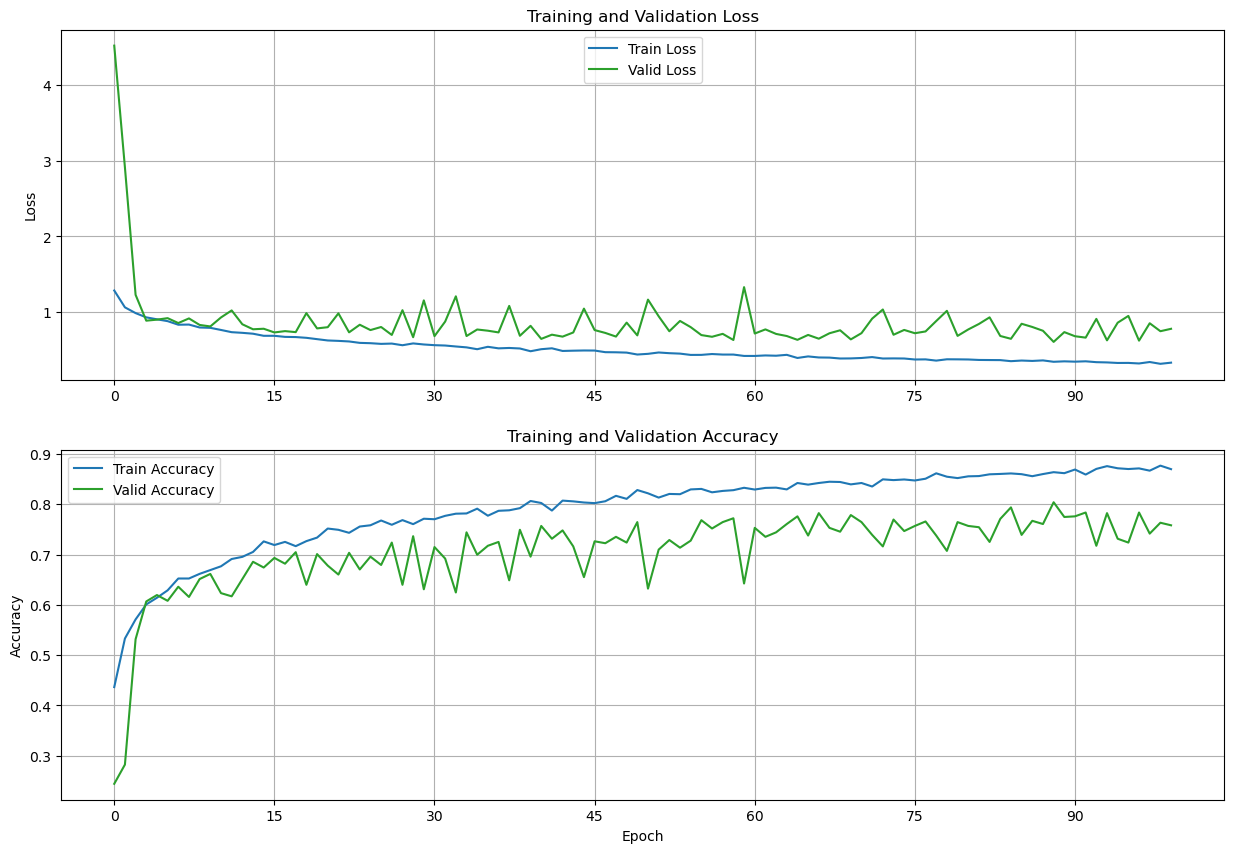

In [48]:
# Plot Loss and Accuracy

loss = training_results.history["loss"]
accuracy = training_results.history["accuracy"]

val_loss = training_results.history["val_loss"]
val_accuracy = training_results.history["val_accuracy"]

plot_history(
    train_loss=loss,
    train_metric=accuracy,
    val_loss=val_loss,
    val_metric=val_accuracy,
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
)

In [57]:
# Save the trained model
MODEL_PATH = "cnn_model_v3.h5"

trained_model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to cnn_model_v3.h5


In [59]:
#predict images
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = './dataset/Test/1017401.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input
img_array = image.img_to_array(img)  # Convert to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize pixel values (if required)

# Load the saved model
model = keras.models.load_model(MODEL_PATH)
# Make prediction
predictions = model.predict(img_array)

print(predictions)

# Map the prediction to the class label
class_labels = ['cow', 'elephant', 'horse', 'spider']
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted class: {predicted_class_label}")
print(f"Confidence: {predictions[0][predicted_class_index]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
[[6.7623664e-04 1.4950683e-03 1.1126479e-04 9.9771750e-01]]
Predicted class: spider
Confidence: 1.00


In [49]:
def recreate_model(path, load_weights=False, config=DatasetConfig(), **kwargs):
    """
    For reloading trained model
    Args:
        path: current_version checkpoint path
        load_weights: Whether the files saved at path contains model weights
                      or the Entire model configuration
        **kwargs: use to pass additional keyword arguments to the load_model method
    Returns:
        Reinitialized Trained Model
    """

    if load_weights:
        
        # Create model architecture
        model = get_model(num_classes=config.NUM_CLASSES, input_shape=config.DATA_SHAPE)

        # Load trained model best weights.
        path = os.path.join(path, "model.ckpt")
        model.load_weights(path).expect_partial()
    else:
        path = os.path.join(path, "model.keras")
        model = tf.keras.models.load_model(path, **kwargs)

    model.summary()
    return model

In [50]:
load_version = current_version_name
checkpoint_path = os.path.join(training_config.root_checkpoint_dir, load_version) 

trained_model = recreate_model(checkpoint_path)

Model: "Dummy_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_4 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 222, 222, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 222, 222, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 111, 111, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 109, 109, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 52, 52, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 52, 52, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │         589,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,844,990 (7.04 MB)

 Trainable params: 614,916 (2.35 MB)

 Non-trainable params: 240 (960.00 B)

 Optimizer params: 1,229,834 (4.69 MB)

In [51]:
#5.2 Running Inference

def get_sample_predictions(*, model, dataset, total=15):

    imgs = []
    ground_truths = []
    probs = []
    predictions = []

    idx_to_cls = {0: "cow", 1: "elephant", 2: "horse", 3: "spider"}

    print("Generating Predictions...")
    for data, target in dataset:
        model_predictions = model.predict_on_batch(data)
        cls_predicted = np.argmax(model_predictions, axis=-1)
        cls_probs = np.max(model_predictions, axis=-1)
    
        imgs.extend(data.numpy() / 255.)
        ground_truths.extend(target.numpy())
        predictions.extend(cls_predicted)
        probs.extend(cls_probs)
        
        # Displaying only 15 images 
        if data.shape[0] >= total: 
            break

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = (18, 9)
    fig = plt.figure()
    fig.set_facecolor("white")

    for idx in range(total):

        plt.subplot(3, 5, idx + 1)
        img = imgs[idx]
        plt.imshow(img)

        plt.title(f"P:{idx_to_cls[predictions[idx]]}({probs[idx]:.2}), T:{idx_to_cls[ground_truths[idx]]}")
        plt.axis("off")

    fig.savefig("sample_predictions.png")
    plt.show(block=block_plot)
    
    del imgs, ground_truths, probs, predictions
    return

Found 786 files belonging to 4 classes.
Generating Predictions...


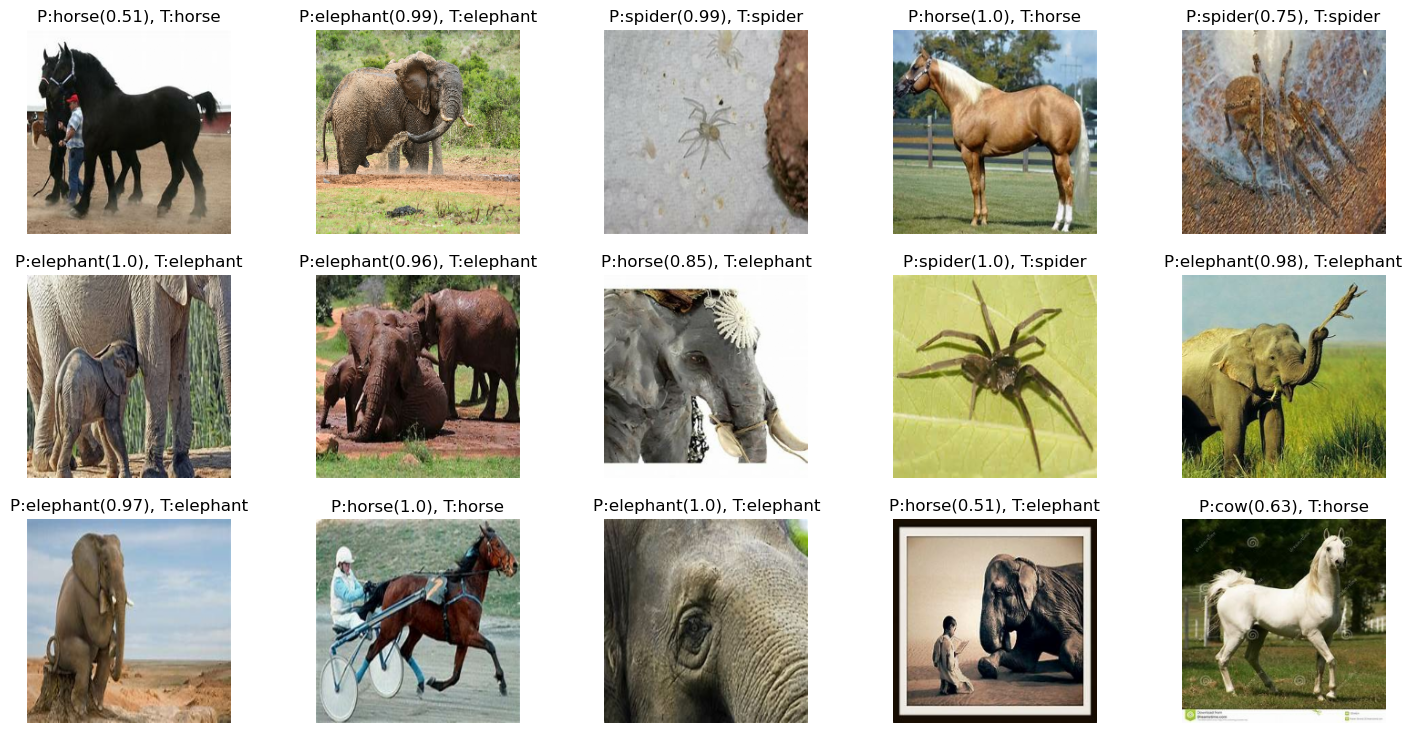

In [52]:
data_config = DatasetConfig()
training_config = TrainingConfig()

valid_path = os.path.join(data_config.DATA_ROOT, "Valid")

valid_dataset = tf.keras.utils.image_dataset_from_directory(
    valid_path, 
    label_mode='int',
    color_mode='rgb', 
    batch_size=training_config.BATCH_SIZE, 
    image_size=data_config.DATA_SHAPE[:2], 
    shuffle=True, # shuffling to show images from all classes
)

get_sample_predictions(model=trained_model, dataset=valid_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


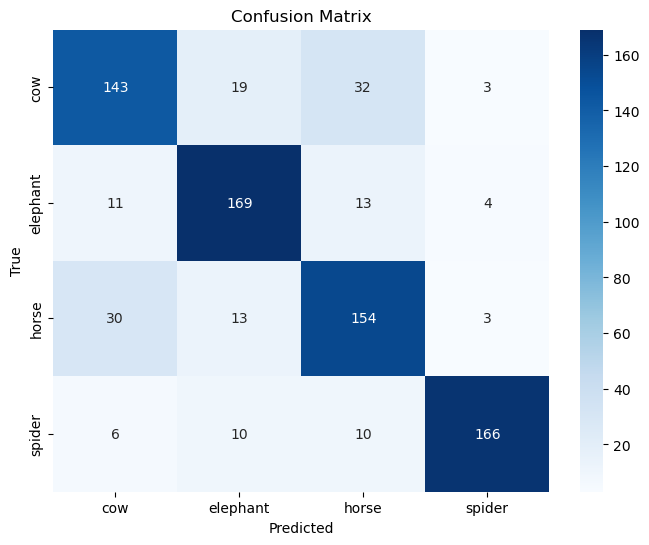

In [53]:
#Step 6. Display Confusion Matrix 

### YOUR CODE HERE
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, dataset, class_names):
    """Displays the confusion matrix for the given model and dataset."""
    
    true_labels = []
    pred_labels = []

    # Iterate through dataset and collect true labels and predictions
    for images, labels in dataset:
        preds = model.predict(images)
        pred_labels.extend(np.argmax(preds, axis=1))  # Convert probabilities to class indices

        # Check if labels are one-hot encoded or integers
        if len(labels.shape) == 1:  # Labels are already integer class indices
            true_labels.extend(labels.numpy())
        else:  # Labels are one-hot encoded, convert them
            true_labels.extend(np.argmax(labels.numpy(), axis=1))

        
     #   true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class indices

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ['cow', 'elephant', 'horse', 'spider']  # Replace with actual class names
plot_confusion_matrix(trained_model, valid_dataset, class_names)
###

In [54]:
#Step 7. Generate Submission File

#option 1: 
import pandas as pd

#test_csv_path = r"/kaggle/input/opencv-tf-project-1-image-classification-round-3/test.csv"
#test_image_dir = r"/kaggle/input/opencv-tf-project-1-image-classification-round-3/dataset/Test"
test_csv_path = r"./test.csv"
test_image_dir = r"./dataset/Test"
IMG_SIZE = (224, 224)

test_df = pd.read_csv(test_csv_path)
test_images = []
image_ids = []

test_ids = test_df['ID'].tolist()
CLASS_NAMES=['cow', 'elephant', 'horse', 'spider']

for img_id in test_ids:
    img_path = os.path.join(test_image_dir, f"{img_id}")

    if not os.path.exists(img_path):
        warnings.warn(f"Image not found: {img_path}")
        continue #Skip this image
    
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)/255.0     # rescale to [0, 1]

    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    test_images.append(img_array)
    image_ids.append(img_id)

test_images = np.vstack(test_images)  # Stack all images into a single NumPy array

#predictions = []
#for img_array in test_images:
#    pred = trained_model.predict(img_array)
        
#    accuracy = tf.reduce_max(pred).numpy()  # Max probability as "Accuracy"
#    predictions.append(accuracy)

# Predict on test images
predictions = trained_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)  # Get class index
predicted_class_names = [CLASS_NAMES[idx] for idx in predicted_classes]  # Convert to class names
accuracy_scores = np.max(predictions, axis=1)  # Get highest probability as accuracy

# Create submission file
submission_df = pd.DataFrame({
    'ID': image_ids,
    'Class': predicted_class_names,
    'Accuracy': accuracy_scores
})

# Save results
submission_df.to_csv("sample_submission_v3.csv", index=False)
print("Test results saved to 'sample_submission.csv' successfully!") 

52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 283ms/step
Test results saved to 'sample_submission.csv' successfully!


In [56]:
print(predictions)

[[6.7623984e-04 1.4950747e-03 1.1126499e-04 9.9771744e-01]
 [7.1846560e-04 1.4185904e-03 1.1865728e-04 9.9774432e-01]
 [9.0933114e-04 2.3302352e-03 1.4803254e-04 9.9661225e-01]
 ...
 [9.6975506e-04 2.9223834e-03 1.7841178e-04 9.9592942e-01]
 [9.6004718e-04 2.2983337e-03 1.6314381e-04 9.9657851e-01]
 [6.9152756e-04 1.6698778e-03 1.1886679e-04 9.9751967e-01]]
